In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


In [2]:
data_file_train = "/kaggle/input/playground-series-s3e20/train.csv"
data_file_test = "/kaggle/input/playground-series-s3e20/test.csv"

In [3]:
X_train_full = pd.read_csv(data_file_train)
X_test_full = pd.read_csv(data_file_test)
X_train_full.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1, inplace=True)
X_test_full.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1, inplace=True)

In [4]:
X_train_full.head()

latitude  longitude  year  week_no  \
0     -0.51      29.29  2019        0   
1     -0.51      29.29  2019        1   
2     -0.51      29.29  2019        2   
3     -0.51      29.29  2019        3   
4     -0.51      29.29  2019        4   

   SulphurDioxide_SO2_column_number_density  \
0                                 -0.000108   
1                                  0.000021   
2                                  0.000514   
3                                       NaN   
4                                 -0.000079   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                           NaN   
4                                      0.676296   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                       -0.000065   
1                                        0.000014   
2                                        0.000385   
3                                             NaN   
4                                       -0.000048   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                       0.255668                           -98.593887   
1                       0.130988                            16.592861   
2                       0.110018                            72.795837   
3                            NaN                                  NaN   
4                       0.121164                             4.121269   

   SulphurDioxide_sensor_zenith_angle  ...  Cloud_cloud_top_height  \
0                           50.843559  ...             3664.436218   
1                           39.137194  ...             3651.190311   
2                           52.868816  ...             4216.986492   
3                                 NaN  ...             5228.507736   
4                           35.515587  ...             3980.598120   

   Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0               61085.809570              2615.120483   
1               66969.478735              3174.572424   
2               60068.894448              3516.282669   
3               51064.547339              4180.973322   
4               63751.125781              3355.710107   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                  15.568533              0.272292   
1                   8.690601              0.256830   
2                  21.103410              0.251101   
3                  15.386899              0.262043   
4                   8.114694              0.235847   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                  -12.628986                  35.632416   
1                   30.359375                  39.557633   
2                   15.377883                  30.401823   
3                  -11.293399                  24.380357   
4                   38.532263                  37.392979   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  emission  
0                -138.786423                 30.752140  3.750994  
1                -145.183930                 27.251779  4.025176  
2                -142.519545                 26.193296  4.231381  
3                -132.665828                 28.829155  4.305286  
4                -141.509805                 22.204612  4.347317  

[5 rows x 75 columns]

In [5]:
X_test_full.head()

latitude  longitude  year  week_no  \
0     -0.51      29.29  2022        0   
1     -0.51      29.29  2022        1   
2     -0.51      29.29  2022        2   
3     -0.51      29.29  2022        3   
4     -0.51      29.29  2022        4   

   SulphurDioxide_SO2_column_number_density  \
0                                       NaN   
1                                  0.000456   
2                                  0.000161   
3                                  0.000350   
4                                 -0.000317   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                           NaN   
1                                      0.691164   
2                                      0.605107   
3                                      0.696917   
4                                      0.580527   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                             NaN   
1                                        0.000316   
2                                        0.000106   
3                                        0.000243   
4                                       -0.000184   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                            NaN                                  NaN   
1                       0.000000                            76.239196   
2                       0.079870                           -42.055341   
3                       0.201028                            72.169566   
4                       0.204352                            76.190865   

   SulphurDioxide_sensor_zenith_angle  ...  Cloud_cloud_top_pressure  \
0                                 NaN  ...              36022.027344   
1                           15.600607  ...              48539.737242   
2                           39.889060  ...              34133.080469   
3                           58.862543  ...              50854.991076   
4                           15.646016  ...              46594.685145   

   Cloud_cloud_top_height  Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0             8472.313477               41047.937500              7472.313477   
1             6476.147323               54915.708579              5476.147161   
2             8984.795703               39006.093750              7984.795703   
3             6014.724059               57646.368368              5014.724115   
4             6849.280477               52896.541873              5849.280394   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                   7.935617              0.240773   
1                  11.448437              0.293119   
2                  10.753179              0.267130   
3                  11.764556              0.304679   
4                  13.065317              0.284221   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                 -100.113792                  33.697044   
1                  -30.510319                  42.402593   
2                   39.087361                  45.936480   
3                  -24.465127                  42.140419   
4                  -12.907850                  30.122641   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  
0                -133.047546                 33.779583  
1                -138.632822                 31.012380  
2                -144.784988                 26.743361  
3                -135.027891                 29.604774  
4                -135.500119                 26.276807  

[5 rows x 74 columns]

In [6]:
print(X_train_full.shape)
print(X_test_full.shape)

(79023, 75)
(24353, 74)


In [7]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['missing#'] = df.isna().sum().values*100
    summ['missing%'] = (df.isna().sum().values*100)/len(df)
    summ['uniques'] = df.nunique().values
    summ['count'] = df.count().values
    desc = pd.DataFrame(df.describe().T)
    summ['min'] = desc['min']
    summ['max'] = desc['max']
    summ['mean'] = desc['mean']
    return summ

summary(X_train_full).style.background_gradient(cmap='Blues')

/tmp/ipykernel_20/3760621081.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', ax = ax, linewidth = 2.1)
/tmp/ipykernel_20/3760621081.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


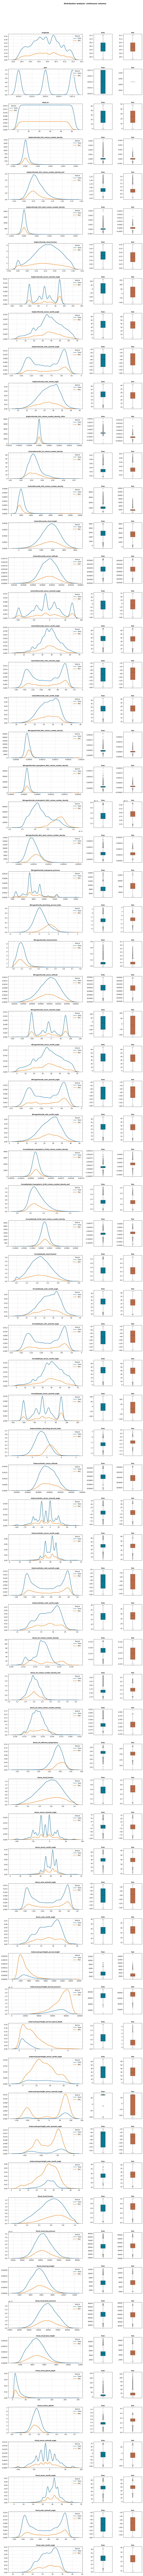

In [8]:
#from YANG ZHOU: https://www.kaggle.com/code/yaaangzhou/en-playground-s3-e20-eda-modeling#-0.-Imports-
num = X_train_full.columns.tolist()[1:-1]
df = pd.concat([X_train_full[num].assign(Source = 'Train'), 
                X_test_full[num].assign(Source = 'Test')], 
               axis=0, ignore_index = True);

fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4.2), 
                         gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]});

for i,col in enumerate(num):
    ax = axes[i,0];
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
    ax = axes[i,1];
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

    ax = axes[i,2];
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                saturation = 0.6, linewidth = 0.90, color = '#E4591E',
                ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');
    
plt.suptitle(f"\nDistribution analysis- continuous columns\n",fontsize = 12, fontweight= 'bold',
             y = 0.89, x = 0.57);
plt.tight_layout();
plt.show();

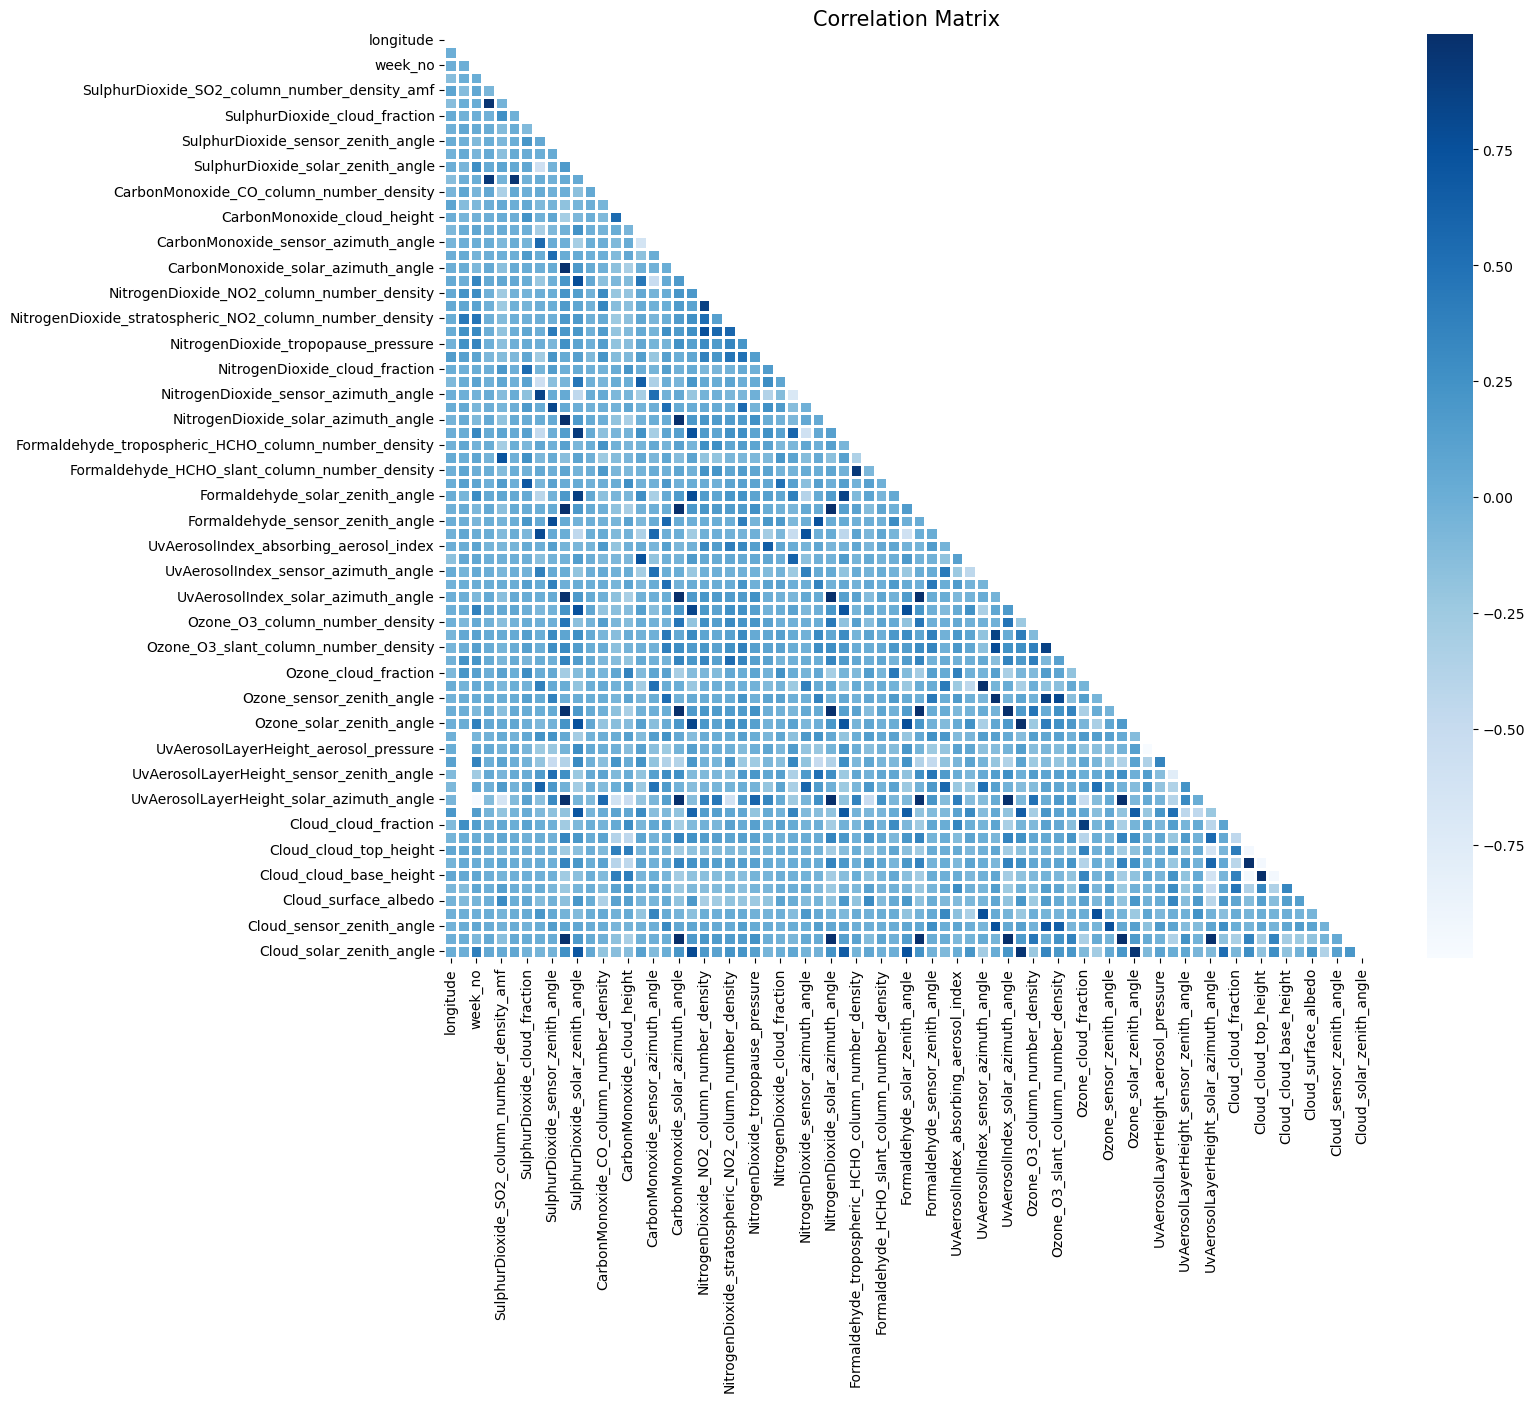

In [9]:
# Correlation

corr_matrix = X_train_full[num].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

In [10]:
y = X_train_full['emission']
X_train_full.drop(['emission'], axis=1, inplace=True)
X_train_split, X_valid_split, y_train, y_valid = train_test_split(X_train_full, y, train_size=0.8, test_size=0.2)

In [11]:
all_cols = X_train_full.columns.tolist()
delete_cols = [
    'UvAerosolLayerHeight_aerosol_height',
    'UvAerosolLayerHeight_aerosol_pressure',
    'UvAerosolLayerHeight_aerosol_optical_depth',
    'UvAerosolLayerHeight_sensor_zenith_angle',
    'UvAerosolLayerHeight_sensor_azimuth_angle',
    'UvAerosolLayerHeight_solar_azimuth_angle',
    'UvAerosolLayerHeight_solar_zenith_angle'
]
cat_cols = ['year','week_no']
num_cols = list(set(all_cols) - set(delete_cols) - set(cat_cols))
print(num_cols)

['Formaldehyde_tropospheric_HCHO_column_number_density_amf', 'NitrogenDioxide_NO2_slant_column_number_density', 'Cloud_cloud_optical_depth', 'SulphurDioxide_SO2_column_number_density_amf', 'CarbonMonoxide_solar_zenith_angle', 'NitrogenDioxide_solar_zenith_angle', 'NitrogenDioxide_absorbing_aerosol_index', 'Formaldehyde_sensor_zenith_angle', 'Ozone_sensor_zenith_angle', 'CarbonMonoxide_sensor_altitude', 'NitrogenDioxide_tropopause_pressure', 'CarbonMonoxide_sensor_azimuth_angle', 'UvAerosolIndex_absorbing_aerosol_index', 'Ozone_O3_column_number_density', 'longitude', 'Ozone_cloud_fraction', 'Cloud_solar_azimuth_angle', 'CarbonMonoxide_cloud_height', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 'Formaldehyde_cloud_fraction', 'NitrogenDioxide_NO2_column_number_density', 'Ozone_solar_zenith_angle', 'Cloud_surface_albedo', 'Ozone_O3_slant_column_number_density', 'Cloud_solar_zenith_angle', 'NitrogenDioxide_cloud_fraction', 'Cloud_sensor_azimuth_angle', 'Cloud_cloud_fraction', 

In [12]:
print(type(cat_cols),type(num_cols))

<class 'list'> <class 'list'>


In [13]:
cat_pipeline = Pipeline(steps=
                         [('imputer',SimpleImputer(strategy="most_frequent")),
                          ('onehot', OneHotEncoder(handle_unknown='ignore')),
                          ])

num_pipeline = Pipeline(steps=
                         [('imputer',KNNImputer(n_neighbors=5)),
                          ('scaler', MinMaxScaler()),
                          ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_pipeline,num_cols),
        ('cate',cat_pipeline,cat_cols)
    ]
)

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor(n_estimators=500,learning_rate=0.1))
    ]
)

In [14]:
clf.fit(X_train_split, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Formaldehyde_tropospheric_HCHO_column_number_density_amf',
                                                   'NitrogenDioxide_NO2_slant_column_number_density',
                                                   'Cloud_cloud_optical_depth',
                                                   'SulphurDioxide_SO2_column_number_density_amf',
                                                   'CarbonMonoxide_solar_zen...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=500,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [15]:
preds = clf.predict(X_valid_split)

In [16]:
submition = clf.predict(X_test_full)

In [17]:
X_test_full = pd.read_csv(data_file_test, index_col='ID_LAT_LON_YEAR_WEEK')
output = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': X_test_full.index,
                       'emission': submition})
output.to_csv('submission.csv', index=False)